## Импорты

In [75]:
import pandas as pd
import numpy as np

from typing import Optional, Dict, NoReturn, Callable, Any, Iterator, Self, Tuple, overload, Sequence, Literal

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import models, transforms

from os import PathLike
import gc
from PIL import Image

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

## Загрузчик и обработчик изображений

**Пишу свой ImageLoader, ImageDataset и Image т.к. `torch.utils.data` умеет определять классы только в разделенных папках, а еще он неудобный**

In [2]:
class ImageTensor:
    def __init__(self,
                 filepath: PathLike,
                 label: int,
                 transform: Optional[Callable[[Image.Image], torch.tensor]] = None,
                 **kwargs) -> None:
        self.filepath = filepath
        self.label = label
        self.transform = transform
        self.additional_attributes = kwargs
    
    @property
    def tensor(self) -> torch.Tensor:
        image = Image.open(self.filepath)
        tensor = torch.Tensor(np.array(image)).to(torch.uint8) if self.transform is None else self.transform(image)
        image.close()
        return tensor

    def _repr_jpeg_(self) -> bytes:
        print('Label:', self.label)
        print(self.additional_attributes)
        return Image.open(self.filepath)._repr_image('jpeg')

In [3]:
class ImageDataset:
    def __init__(self,
                 data: Sequence[ImageTensor],
                 indexes: Optional[Sequence[int]] = None) -> None | NoReturn:
        self.data = np.array(data, dtype='object')
        if indexes is not None:
            if len(indexes) != self.data.shape[0]:
                raise IndexError('length of `indexes` must be equal to length')
            self.indexes = np.array(indexes, dtype=np.int16)
        else:
            self.indexes = np.arange(self.data.shape[0], dtype=np.int16)
    
    @staticmethod
    def image_factory(filepaths: Sequence[PathLike],
                      label: Sequence[int],
                      transform: Optional[Callable[[Image.Image], torch.tensor]] = None,
                      additional_attributes: Optional[Dict[str, Sequence[Any]]] = None,
                      indexes: Optional[Sequence[int]] = None) -> Self:
        if additional_attributes is not None:
            data = [ImageTensor(fp, l, transform, **dict(zip(additional_attributes.keys(), aa))) for fp, l, *aa in zip(filepaths, label, *additional_attributes.values(), strict=True)]
        else:
            data = [ImageTensor(fp, l, transform) for fp, l in zip(filepaths, label)]
        return ImageDataset(data=data, indexes=indexes)
        
    @overload
    def __getitem__(self, indexes: int) -> ImageTensor: ...

    @overload
    def __getitem__(self, indexes: Sequence[int]) -> np.ndarray[ImageTensor]: ...

    def __getitem__(self, indexes: int | Sequence[int]) -> ImageTensor | np.ndarray[ImageTensor]:
        indexes = self.indexes[indexes]
        return self.data[indexes]
    
    @overload
    def get_tensors(self, indexes: int, device: torch.device = 'cpu') -> Tuple[int, torch.Tensor]: ...

    @overload
    def get_tensors(self, indexes: Sequence[int], device: torch.device = 'cpu') -> Tuple[torch.Tensor, torch.Tensor]: ...

    def get_tensors(self, indexes: int | Sequence[int], device: torch.device = 'cpu') -> Tuple[torch.Tensor, torch.Tensor] | Tuple[int, torch.Tensor]:
        if isinstance(indexes, int):
            img = self[indexes]
            return img.label, img.tensor.to(device=device, non_blocking=True)
        else:
            imgs = self[indexes]
            return torch.Tensor([i.label for i in imgs]).to(device=device, non_blocking=True), torch.stack([i.tensor for i in imgs]).to(device=device, non_blocking=True)
    
    def __len__(self) -> int:
        return self.data.shape[0]
    
    def __iter__(self) -> Iterator[ImageTensor]:
        return iter(self.data)
    
    def batch_iter_items(self, batch_size: int = 1) -> Iterator[np.ndarray[ImageTensor]]:
        for i in range(0, len(self), batch_size):
            yield self.data[i:i+batch_size]

    def batch_iter_labels_only(self, batch_size: int = 1, device: torch.device = 'cpu') -> Iterator[torch.Tensor]:
        get_labels = np.vectorize(lambda x: x.label)
        for i in range(0, len(self), batch_size):
            imgs = self.data[i:i+batch_size]
            yield torch.Tensor(get_labels(imgs)).to(device=device, non_blocking=True)

    def batch_iter_tensors(self, batch_size: int = 1, device: torch.device = 'cpu') -> Iterator[Tuple[torch.Tensor, torch.Tensor]]:
        get_labels = np.vectorize(lambda x: x.label)
        for i in range(0, len(self), batch_size):
            imgs = self.data[i:i+batch_size]
            tensors = [i.tensor for i in imgs]
            yield torch.Tensor(get_labels(imgs)).to(device=device, non_blocking=True), torch.stack(tensors).to(device=device, non_blocking=True)

In [4]:
class Classifier(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super(Classifier, self).__init__(*args, **kwargs)

    def forward(self, x: torch.Tensor):
        return self.backbone(x)

    def train_model(self,
                    data: ImageDataset,
                    validation_data: Optional[ImageDataset] = None,
                    save_best_model: bool = False,
                    batch_size: int = 32,
                    epochs: int = 10,
                    backbone_learning_rate: float = 0.0001,
                    classifier_learning_rate: float = 0.001,
                    mixed_precision: bool = False) -> pd.DataFrame:
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW([
            {'params': self._backbone_pointer.parameters(), 'lr': backbone_learning_rate},
            {'params': self._classifier_pointer.parameters(), 'lr': classifier_learning_rate}
        ])
        if mixed_precision:
            scaler = torch.amp.grad_scaler.GradScaler(device=self.device)
        val_accuracy = []
        train_loss = []
        self.train()
        for epoch in range(epochs):
            running_loss = 0.0
            for labels, tensors in data.batch_iter_tensors(batch_size, device=self.device):
                optimizer.zero_grad()
                if mixed_precision:
                    with torch.amp.autocast_mode.autocast(self.device.type):
                        output = self(tensors)
                        loss = criterion(output, labels.long())
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    output = self(tensors)
                    loss = criterion(output, labels.long())
                    loss.backward()
                    optimizer.step()
                running_loss += loss.item()
            train_loss.append(running_loss / len(data))
            if validation_data is not None:
                y_pred = self.predict(validation_data, batch_size=batch_size)
                y_true = np.array([i.label for i in validation_data])
                accuracy = np.sum(y_true == y_pred) / len(y_true)
                print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(data):.4f}, Validation Accuracy: {accuracy:.4f}")
                if save_best_model:
                    if len(val_accuracy) == 0 or (accuracy > max(val_accuracy)):
                        torch.save(self, f=f'./{self.backbone_name}.pth')
                        print(f'Best model saved: ./{self.backbone_name}.pth')
                val_accuracy.append(accuracy)
            else:
                print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(data):.4f}")
        history = pd.DataFrame()
        history['Epoch'] = list(range(1, epochs+1))
        history['Train Loss'] = train_loss
        if validation_data is not None:
            history['Validation Accuracy'] = val_accuracy
        return history

    def predict(self,
                data: ImageDataset,
                batch_size=32) -> np.ndarray:
        self.eval()
        predictions = []
        with torch.no_grad():
            for _, tensors in data.batch_iter_tensors(batch_size, device=self.device):
                outputs = self(tensors)
                _, predicted = torch.max(outputs, 1)
                predictions.extend(predicted.cpu().numpy())
        return np.array(predictions, dtype=np.uint16)

## Загрузка изображений

In [5]:
df = pd.read_csv('./description.csv')
labels = df['ru_author'].unique()
labels = {j: i for i, j in enumerate(labels)}
df['label'] = df['ru_author'].replace(labels)

def create_dataset(indexes, df, transform) -> ImageDataset:
    df = df.iloc[indexes]
    dataset = ImageDataset.image_factory(filepaths = df['filename'],
                                         label = df['label'],
                                         transform = transform,
                                         indexes = indexes,
                                         additional_attributes = {
                                            'title': df['ru_title'],
                                            'author': df['ru_author']})
    return dataset


C:\Users\FireStrike\AppData\Local\Temp\ipykernel_14828\2334689394.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'] = df['ru_author'].replace(labels)


In [6]:
df['ru_author'].value_counts()

ru_author
Илья Ефимович Репин                528
Исаак Ильич Левитан                393
Василий Иванович Суриков           232
Валентин Александрович Серов       189
Петров-Водкин Кузьма Сергеевич     185
Аполлинарий Михайлович Васнецов    143
Name: count, dtype: int64

**Возьмем по медиане (<=210) от каждой группы**

In [7]:
median = df['ru_author'].value_counts().median()
resampled_df = (
    df.groupby('ru_author', group_keys=False)
      .apply(lambda group: group.sample(n=min(len(group), int(median)), random_state=1337))
).sort_index().reset_index(drop=True)

C:\Users\FireStrike\AppData\Local\Temp\ipykernel_14828\1174528700.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.sample(n=min(len(group), int(median)), random_state=1337))


In [8]:
resampled_df['ru_author'].value_counts()

ru_author
Исаак Ильич Левитан                210
Илья Ефимович Репин                210
Василий Иванович Суриков           210
Валентин Александрович Серов       189
Петров-Водкин Кузьма Сергеевич     185
Аполлинарий Михайлович Васнецов    143
Name: count, dtype: int64

In [10]:
np.random.seed(1337)
indexes = np.array(resampled_df.index, dtype=np.uint16)
np.random.shuffle(indexes)
train_indexes = indexes[:int(indexes.size*0.7)]
val_indexes = indexes[int(indexes.size*0.7):int(indexes.size*0.8)]
test_indexes = indexes[int(indexes.size*0.8):]

In [11]:
print(f"""Количество изображений:
Train: {len(train_indexes)}
Validation: {len(val_indexes)}
Test: {len(test_indexes)}""")

Количество изображений:
Train: 802
Validation: 115
Test: 230


## Функции графиков

In [78]:
def plot_history(history: pd.DataFrame, model_name: str):
    epochs = history['Epoch']
    train_loss = history['Train Loss']
    val_accuracy = history['Validation Accuracy']
    fig, ax1 = plt.subplots(figsize=(8, 6))
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Train Loss', color='tab:blue')
    ax1.plot(epochs, train_loss, color='tab:blue', linestyle='-', linewidth=2, label='Train Loss')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Validation Accuracy', color='tab:red')
    ax2.plot(epochs, val_accuracy, color='tab:red', linestyle='--', linewidth=2, label='Validation Accuracy')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    plt.title(model_name)
    fig.tight_layout()
    plt.show()

In [127]:
def plot_confusion_matrix_with_accuracy(model: Classifier,
                                        test_dataset: ImageDataset,
                                        batch_size: int = 32,
                                        model_name: Optional[str] = None):
    y_pred = model.predict(test_dataset, batch_size=batch_size)
    y = np.array([i.label for i in test_dataset])
    print(f'Всего предсказаний: {len(y_pred)}')
    correct_predictions = np.sum(y == y_pred)
    print(f'Количество правильных предсказаний: {correct_predictions}')
    accuracy = correct_predictions / len(y)
    print(f'Относительное количество правильных предсказаний: {accuracy:.4f}')
    cm = confusion_matrix(y, y_pred)
    fig = ConfusionMatrixDisplay(cm, display_labels=labels)
    fig.plot()
    ax = fig.ax_
    ax.set_title(model_name)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

## Модель EfficientNetB2

![EfficiNet Table](https://www.researchgate.net/publication/356462299/figure/tbl1/AS:1094950984925218@1638068066728/Comparison-of-different-EfficientNet-models.png)<br>

In [123]:
data_transforms = transforms.Compose([transforms.Resize((260, 260)),  # EfficientNetB2
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(15),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [124]:
train_dataset = create_dataset(train_indexes, resampled_df, data_transforms)
val_dataset = create_dataset(val_indexes, resampled_df, data_transforms)
test_dataset = create_dataset(test_indexes, resampled_df, data_transforms)
num_classes = len(df['ru_author'].unique())

In [125]:
class EfficientNetB2Classifier(Classifier):
    def __init__(self, num_classes: int, pretrained: bool = True, classifier_dropout: float = 0.25, *args, **kwargs) -> None:
        super(EfficientNetB2Classifier, self).__init__(*args, **kwargs)
        self.backbone = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.DEFAULT if pretrained else None)
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(classifier_dropout),
            nn.Linear(in_features, num_classes)
        )
        self._classifier_pointer = self.backbone.classifier
        self._backbone_pointer = self.backbone.features
        self.backbone_name = 'EfficientNetB2'
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f'Model would work on {self.device}')
        self.to(self.device)

In [26]:
model = EfficientNetB2Classifier(num_classes, classifier_dropout=0.25)
history = model.train_model(data=train_dataset,
                            validation_data=val_dataset,
                            save_best_model=True,
                            batch_size=8,
                            epochs=25,
                            backbone_learning_rate=0.0001,
                            classifier_learning_rate=0.001,
                            mixed_precision=True)
history.to_csv('./EfficientNetB2_Learning_History.csv')

Model would work on cuda
Epoch 1/25, Loss: 0.1580, Validation Accuracy: 0.6783
Best model saved: ./EfficientNetB2.pth
Epoch 2/25, Loss: 0.0897, Validation Accuracy: 0.7304
Best model saved: ./EfficientNetB2.pth
Epoch 3/25, Loss: 0.0412, Validation Accuracy: 0.7130
Epoch 4/25, Loss: 0.0252, Validation Accuracy: 0.7565
Best model saved: ./EfficientNetB2.pth
Epoch 5/25, Loss: 0.0197, Validation Accuracy: 0.7304
Epoch 6/25, Loss: 0.0160, Validation Accuracy: 0.7913
Best model saved: ./EfficientNetB2.pth
Epoch 7/25, Loss: 0.0204, Validation Accuracy: 0.7652
Epoch 8/25, Loss: 0.0038, Validation Accuracy: 0.7565
Epoch 9/25, Loss: 0.0081, Validation Accuracy: 0.7478
Epoch 10/25, Loss: 0.0011, Validation Accuracy: 0.8000
Best model saved: ./EfficientNetB2.pth
Epoch 11/25, Loss: 0.0001, Validation Accuracy: 0.8000
Epoch 12/25, Loss: 0.0001, Validation Accuracy: 0.7652
Epoch 13/25, Loss: 0.0000, Validation Accuracy: 0.7739
Epoch 14/25, Loss: 0.0000, Validation Accuracy: 0.7826
Epoch 15/25, Loss: 

GPU - NVIDIA geforce RTX 3060(6gb laptop) (undervolted)<br>
GPU freq ≈ 900MHz<br>
GPU memory freq ≈ 6000MHz<br>
GPU memory usage ≈ 1.3gb<br>
Training time = 10m 25.4s<br>
Best validation accuracy ≈ 0.8174

In [27]:
del model
del history
gc.collect()
torch.cuda.empty_cache()

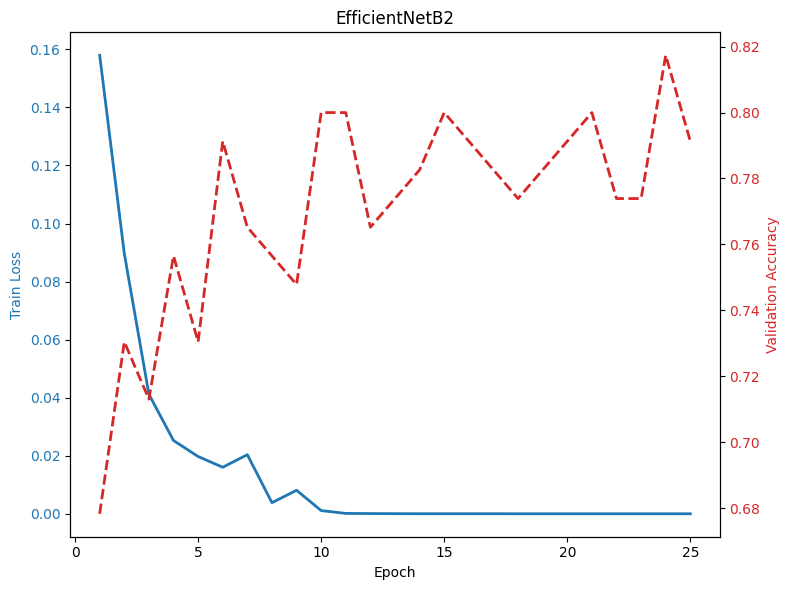

In [79]:
plot_history(pd.read_csv('./EfficientNetB2_Learning_History.csv', index_col=0), model_name='EfficientNetB2')

Всего предсказаний: 230
Количество правильных предсказаний: 182
Относительное количество правильных предсказаний: 0.7913


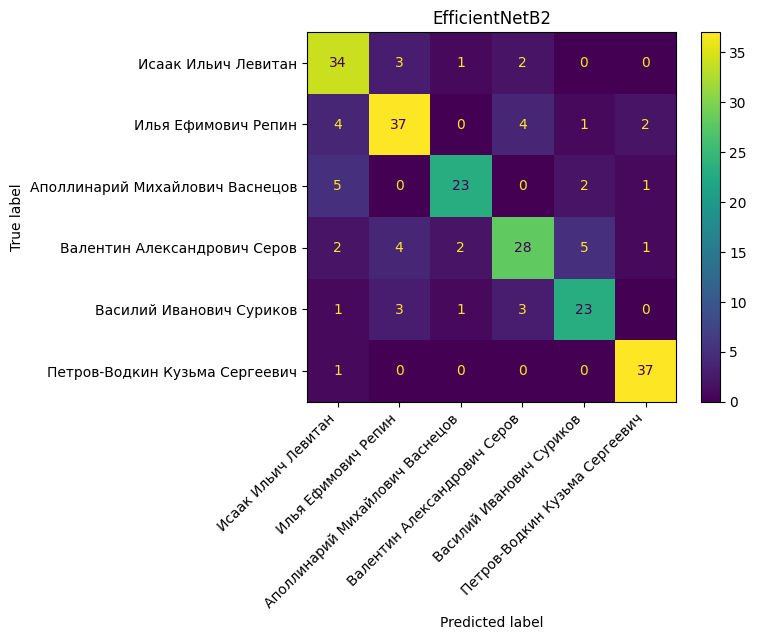

In [128]:
plot_confusion_matrix_with_accuracy(torch.load('./EfficientNetB2.pth'), test_dataset=test_dataset, model_name='EfficientNetB2')
gc.collect()
torch.cuda.empty_cache()

## Модель EfficientNetB3

In [118]:
data_transforms = transforms.Compose([transforms.Resize((300, 300)),  # EfficientNetB3
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(15),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [119]:
train_dataset = create_dataset(train_indexes, resampled_df, data_transforms)
val_dataset = create_dataset(val_indexes, resampled_df, data_transforms)
test_dataset = create_dataset(test_indexes, resampled_df, data_transforms)
num_classes = len(df['ru_author'].unique())

In [121]:
class EfficientNetB3Classifier(Classifier):
    def __init__(self, num_classes: int, pretrained: bool = True, classifier_dropout: float = 0.25, *args, **kwargs) -> None:
        super(EfficientNetB3Classifier, self).__init__(*args, **kwargs)
        self.backbone = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT if pretrained else None)
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(classifier_dropout),
            nn.Linear(in_features, num_classes)
        )
        self._classifier_pointer = self.backbone.classifier
        self._backbone_pointer = self.backbone.features
        self.backbone_name = 'EfficientNetB3'
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f'Model would work on {self.device}')
        self.to(self.device)

In [15]:
model = EfficientNetB3Classifier(num_classes, classifier_dropout=0.25)
history = model.train_model(data=train_dataset,
                            validation_data=val_dataset,
                            save_best_model=True,
                            batch_size=8,
                            epochs=25,
                            backbone_learning_rate=0.0001,
                            classifier_learning_rate=0.001,
                            mixed_precision=True)
history.to_csv('./EfficientNetB3_Learning_History.csv')

Model would work on cuda
Epoch 1/25, Loss: 0.1681, Validation Accuracy: 0.6957
Best model saved: ./EfficientNetB3.pth
Epoch 2/25, Loss: 0.0887, Validation Accuracy: 0.7826
Best model saved: ./EfficientNetB3.pth
Epoch 3/25, Loss: 0.0382, Validation Accuracy: 0.8087
Best model saved: ./EfficientNetB3.pth
Epoch 4/25, Loss: 0.0210, Validation Accuracy: 0.7739
Epoch 5/25, Loss: 0.0207, Validation Accuracy: 0.7739
Epoch 6/25, Loss: 0.0173, Validation Accuracy: 0.7565
Epoch 7/25, Loss: 0.0041, Validation Accuracy: 0.8087
Epoch 8/25, Loss: 0.0074, Validation Accuracy: 0.8174
Best model saved: ./EfficientNetB3.pth
Epoch 9/25, Loss: 0.0026, Validation Accuracy: 0.8174
Epoch 10/25, Loss: 0.0012, Validation Accuracy: 0.8087
Epoch 11/25, Loss: 0.0005, Validation Accuracy: 0.8000
Epoch 12/25, Loss: 0.0000, Validation Accuracy: 0.8348
Best model saved: ./EfficientNetB3.pth
Epoch 13/25, Loss: 0.0001, Validation Accuracy: 0.8000
Epoch 14/25, Loss: 0.0000, Validation Accuracy: 0.8696
Best model saved: .

GPU - NVIDIA geforce RTX 3060(6gb laptop) (undervolted)<br>
GPU freq ≈ 900MHz<br>
GPU memory freq ≈ 6000MHz<br>
GPU memory usage ≈ 1.9gb<br>
Training time = 11m 50.0s<br>
Best validation accuracy ≈ 0.8696

In [18]:
del model
del history
gc.collect()
torch.cuda.empty_cache()

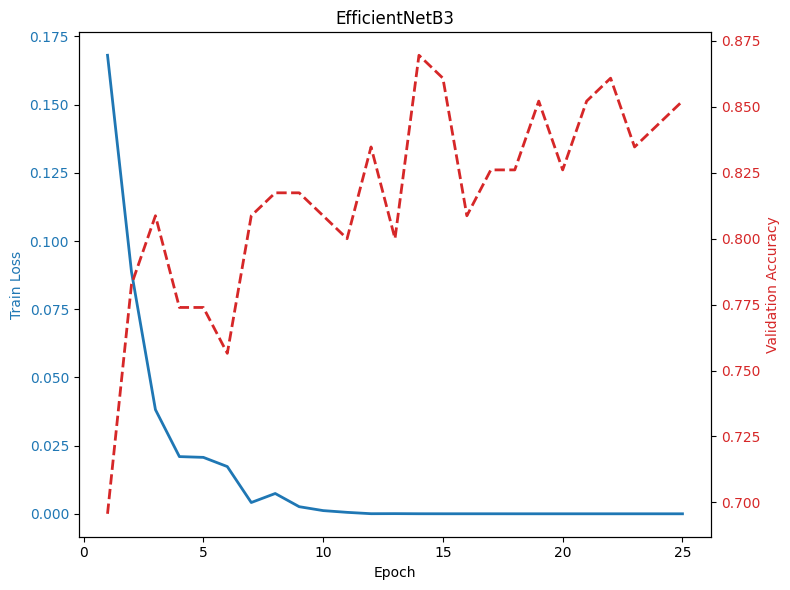

In [80]:
plot_history(pd.read_csv('./EfficientNetB3_Learning_History.csv', index_col=0), model_name='EfficientNetB3')

Всего предсказаний: 230
Количество правильных предсказаний: 189
Относительное количество правильных предсказаний: 0.8217


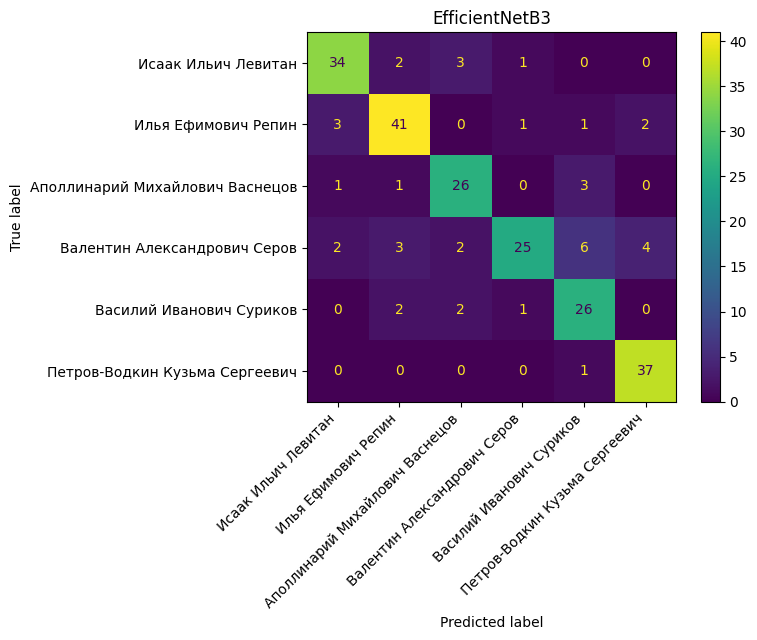

In [129]:
plot_confusion_matrix_with_accuracy(torch.load('./EfficientNetB3.pth'), test_dataset=test_dataset, model_name='EfficientNetB3')
gc.collect()
torch.cuda.empty_cache()

## Модель EfficientNetB4

In [114]:
data_transforms = transforms.Compose([transforms.Resize((380, 380)),  # EfficientNetB4
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(15),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [115]:
train_dataset = create_dataset(train_indexes, resampled_df, data_transforms)
val_dataset = create_dataset(val_indexes, resampled_df, data_transforms)
test_dataset = create_dataset(test_indexes, resampled_df, data_transforms)
num_classes = len(df['ru_author'].unique())

In [116]:
class EfficientNetB4Classifier(Classifier):
    def __init__(self, num_classes: int, pretrained: bool = True, classifier_dropout: float = 0.25, *args, **kwargs) -> None:
        super(EfficientNetB4Classifier, self).__init__(*args, **kwargs)
        self.backbone = models.efficientnet_b4(weights=models.EfficientNet_B4_Weights.DEFAULT if pretrained else None)
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(classifier_dropout),
            nn.Linear(in_features, num_classes)
        )
        self._classifier_pointer = self.backbone.classifier
        self._backbone_pointer = self.backbone.features
        self.backbone_name = 'EfficientNetB4'
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f'Model would work on {self.device}')
        self.to(self.device)

In [ ]:
model = EfficientNetB4Classifier(num_classes, classifier_dropout=0.25)
history = model.train_model(data=train_dataset,
                            validation_data=val_dataset,
                            save_best_model=True,
                            batch_size=8,
                            epochs=25,
                            backbone_learning_rate=0.0001,
                            classifier_learning_rate=0.001,
                            mixed_precision=True)
history.to_csv('./EfficientNetB4_Learning_History.csv')

Model would work on cuda
Epoch 1/25, Loss: 0.1838, Validation Accuracy: 0.6522
Best model saved: ./EfficientNetB4.pth
Epoch 2/25, Loss: 0.0901, Validation Accuracy: 0.7304
Best model saved: ./EfficientNetB4.pth
Epoch 3/25, Loss: 0.0428, Validation Accuracy: 0.7739
Best model saved: ./EfficientNetB4.pth
Epoch 4/25, Loss: 0.0183, Validation Accuracy: 0.7652
Epoch 5/25, Loss: 0.0129, Validation Accuracy: 0.7739
Epoch 6/25, Loss: 0.0088, Validation Accuracy: 0.8435
Best model saved: ./EfficientNetB4.pth
Epoch 7/25, Loss: 0.0033, Validation Accuracy: 0.8435
Epoch 8/25, Loss: 0.0043, Validation Accuracy: 0.8522
Best model saved: ./EfficientNetB4.pth
Epoch 9/25, Loss: 0.0017, Validation Accuracy: 0.8522
Epoch 10/25, Loss: 0.0003, Validation Accuracy: 0.8435
Epoch 11/25, Loss: 0.0002, Validation Accuracy: 0.8087
Epoch 12/25, Loss: 0.0001, Validation Accuracy: 0.8522
Epoch 13/25, Loss: 0.0001, Validation Accuracy: 0.8261
Epoch 14/25, Loss: 0.0001, Validation Accuracy: 0.8435
Epoch 15/25, Loss: 

GPU - NVIDIA geforce RTX 3060(6gb laptop) (undervolted)<br>
GPU freq ≈ 900MHz<br>
GPU memory freq ≈ 6000MHz<br>
GPU memory usage ≈ 3.5gb<br>
Training time = 15m 4.6s<br>
Best validation accuracy ≈ 0.8696

In [39]:
del model
del history
gc.collect()
torch.cuda.empty_cache()

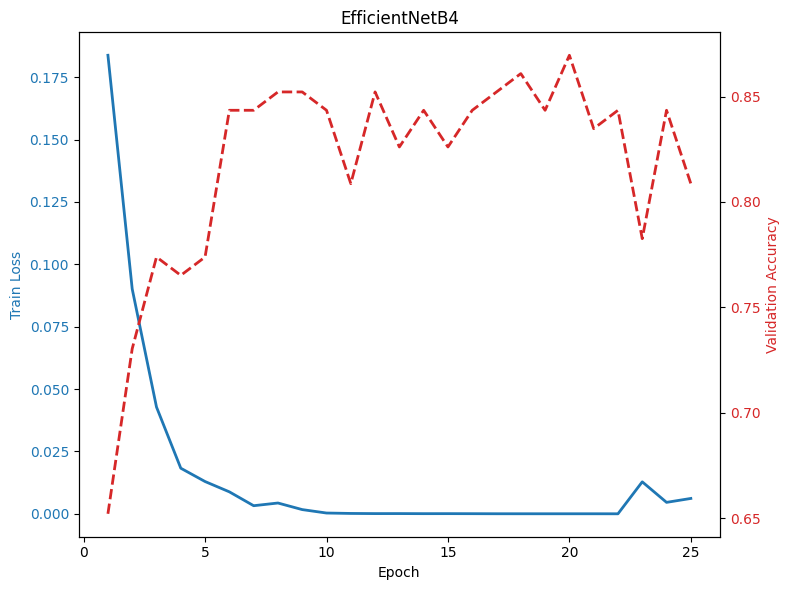

In [81]:
plot_history(pd.read_csv('./EfficientNetB4_Learning_History.csv', index_col=0), model_name='EfficientNetB4')

Всего предсказаний: 230
Количество правильных предсказаний: 176
Относительное количество правильных предсказаний: 0.7652


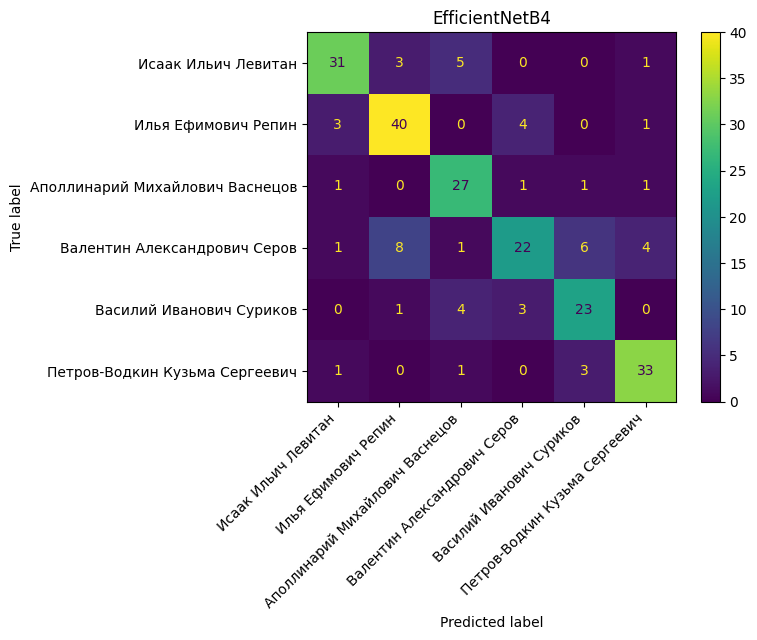

In [130]:
plot_confusion_matrix_with_accuracy(torch.load('./EfficientNetB4.pth'), test_dataset=test_dataset, model_name='EfficientNetB4')
gc.collect()
torch.cuda.empty_cache()

## Модель ResNet34

| Model       | Input Size | Parameters   | Accuracy (%) |
|-------------|------------|--------------|---------------------|
| ResNet-18   | 224x224    | 11.4M        | 69.8               |
| ResNet-34   | 224x224    | 21.5M        | 73.3               |
| ResNet-50   | 224x224    | 23.9M        | 76.2               |
| ResNet-101  | 224x224    | 42.8M        | 77.4               |
| ResNet-152  | 224x224    | 58.5M        | 78.3               |


In [14]:
data_transforms = transforms.Compose([transforms.Resize((224, 224)),  # ResNet
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(15),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [15]:
train_dataset = create_dataset(train_indexes, resampled_df, data_transforms)
val_dataset = create_dataset(val_indexes, resampled_df, data_transforms)
test_dataset = create_dataset(test_indexes, resampled_df, data_transforms)
num_classes = len(df['ru_author'].unique())

In [112]:
class ResNet34Classifier(Classifier):
    def __init__(self, num_classes: int, pretrained: bool = True, classifier_dropout: float = 0.25, *args, **kwargs):
        super(ResNet34Classifier, self).__init__(*args, **kwargs)
        self.backbone = models.resnet34(weights=models.ResNet34_Weights.DEFAULT if pretrained else None)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(classifier_dropout),
            nn.Linear(in_features, num_classes)
        )
        self._classifier_pointer = self.backbone.fc
        self._backbone_pointer = nn.Sequential(*list(self.backbone.children())[:-2])
        self.backbone_name = 'ResNet34'
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f'Model would work on {self.device}')
        self.to(self.device)

In [43]:
model = ResNet34Classifier(num_classes, classifier_dropout=0.25)
history = model.train_model(data=train_dataset,
                            validation_data=val_dataset,
                            save_best_model=True,
                            batch_size=8,
                            epochs=25,
                            backbone_learning_rate=0.0001,
                            classifier_learning_rate=0.001,
                            mixed_precision=True)
history.to_csv('./ResNet34_Learning_History.csv')

Model would work on cuda
Epoch 1/25, Loss: 0.1556, Validation Accuracy: 0.6609
Best model saved: ./ResNet34.pth
Epoch 2/25, Loss: 0.1721, Validation Accuracy: 0.4522
Epoch 3/25, Loss: 0.1413, Validation Accuracy: 0.5739
Epoch 4/25, Loss: 0.1159, Validation Accuracy: 0.6957
Best model saved: ./ResNet34.pth
Epoch 5/25, Loss: 0.1164, Validation Accuracy: 0.6435
Epoch 6/25, Loss: 0.0987, Validation Accuracy: 0.6000
Epoch 7/25, Loss: 0.0978, Validation Accuracy: 0.5913
Epoch 8/25, Loss: 0.0805, Validation Accuracy: 0.5391
Epoch 9/25, Loss: 0.0685, Validation Accuracy: 0.5565
Epoch 10/25, Loss: 0.0698, Validation Accuracy: 0.5130
Epoch 11/25, Loss: 0.0605, Validation Accuracy: 0.6870
Epoch 12/25, Loss: 0.0474, Validation Accuracy: 0.6174
Epoch 13/25, Loss: 0.0531, Validation Accuracy: 0.6348
Epoch 14/25, Loss: 0.0476, Validation Accuracy: 0.6783
Epoch 15/25, Loss: 0.0401, Validation Accuracy: 0.6957
Epoch 16/25, Loss: 0.0561, Validation Accuracy: 0.6696
Epoch 17/25, Loss: 0.0340, Validation 

GPU - NVIDIA geforce RTX 3060(6gb laptop) (undervolted)<br>
GPU freq ≈ 900MHz<br>
GPU memory freq ≈ 6000MHz<br>
GPU memory usage ≈ 0.8gb<br>
Training time = 7m 32.0s<br>
Best validation accuracy ≈ 0.6957

In [44]:
del model
del history
gc.collect()
torch.cuda.empty_cache()

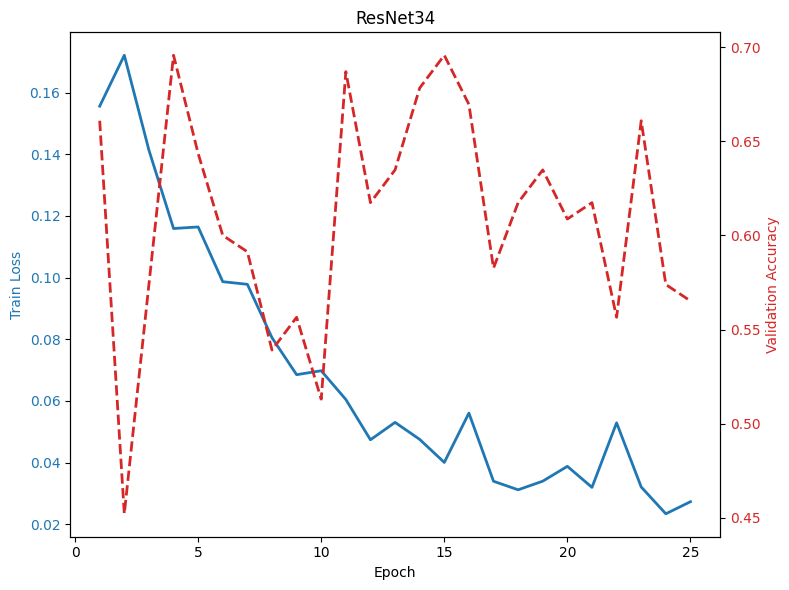

In [82]:
plot_history(pd.read_csv('./ResNet34_Learning_History.csv', index_col=0), model_name='ResNet34')

Всего предсказаний: 230
Количество правильных предсказаний: 154
Относительное количество правильных предсказаний: 0.6696


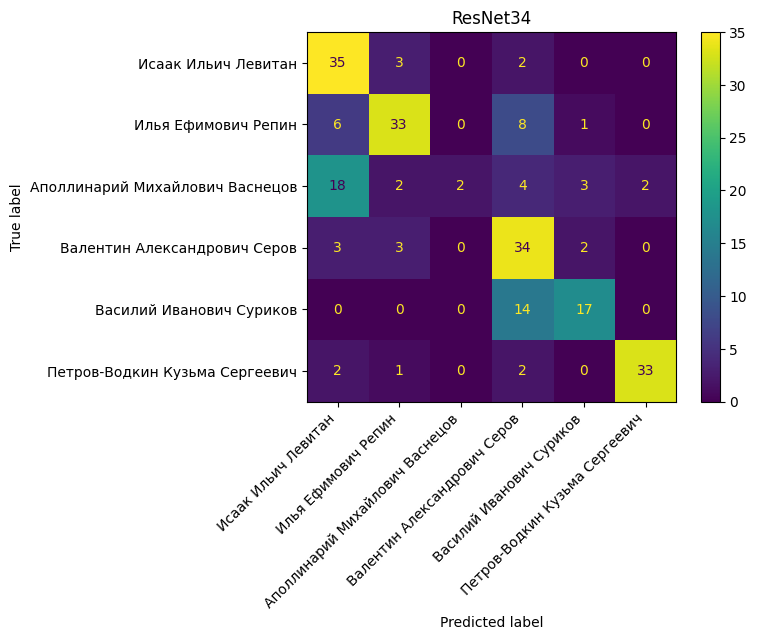

In [131]:
plot_confusion_matrix_with_accuracy(torch.load('./ResNet34.pth'), test_dataset=test_dataset, model_name='ResNet34')
gc.collect()
torch.cuda.empty_cache()

## Модель ResNet50

In [109]:
class ResNet50Classifier(Classifier):
    def __init__(self, num_classes: int, pretrained: bool = True, classifier_dropout: float = 0.25, *args, **kwargs):
        super(ResNet50Classifier, self).__init__(*args, **kwargs)
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT if pretrained else None)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(classifier_dropout),
            nn.Linear(in_features, num_classes)
        )
        self._classifier_pointer = self.backbone.fc
        self._backbone_pointer = nn.Sequential(*list(self.backbone.children())[:-2])
        self.backbone_name = 'ResNet50'
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f'Model would work on {self.device}')
        self.to(self.device)

In [50]:
model = ResNet50Classifier(num_classes, classifier_dropout=0.25)
history = model.train_model(data=train_dataset,
                            validation_data=val_dataset,
                            save_best_model=True,
                            batch_size=8,
                            epochs=25,
                            backbone_learning_rate = 0.0001,
                            classifier_learning_rate = 0.001,
                            mixed_precision=True)
history.to_csv('./ResNet50_Learning_History.csv')

Model would work on cuda
Epoch 1/25, Loss: 0.1537, Validation Accuracy: 0.6957
Best model saved: ./ResNet50.pth
Epoch 2/25, Loss: 0.1277, Validation Accuracy: 0.6522
Epoch 3/25, Loss: 0.1005, Validation Accuracy: 0.7130
Best model saved: ./ResNet50.pth
Epoch 4/25, Loss: 0.0711, Validation Accuracy: 0.6348
Epoch 5/25, Loss: 0.0571, Validation Accuracy: 0.6174
Epoch 6/25, Loss: 0.0464, Validation Accuracy: 0.6957
Epoch 7/25, Loss: 0.0463, Validation Accuracy: 0.7043
Epoch 8/25, Loss: 0.0303, Validation Accuracy: 0.7565
Best model saved: ./ResNet50.pth
Epoch 9/25, Loss: 0.0301, Validation Accuracy: 0.7304
Epoch 10/25, Loss: 0.0354, Validation Accuracy: 0.6870
Epoch 11/25, Loss: 0.0280, Validation Accuracy: 0.7043
Epoch 12/25, Loss: 0.0206, Validation Accuracy: 0.7739
Best model saved: ./ResNet50.pth
Epoch 13/25, Loss: 0.0133, Validation Accuracy: 0.7391
Epoch 14/25, Loss: 0.0240, Validation Accuracy: 0.6522
Epoch 15/25, Loss: 0.0232, Validation Accuracy: 0.7391
Epoch 16/25, Loss: 0.0176, 

GPU - NVIDIA geforce RTX 3060(6gb laptop) (undervolted)<br>
GPU freq ≈ 900MHz<br>
GPU memory freq ≈ 6000MHz<br>
GPU memory usage ≈ 1.0gb<br>
Training time = 8m 20.0s<br>
Best validation accuracy ≈ 0.7826

In [51]:
del model
del history
gc.collect()
torch.cuda.empty_cache()

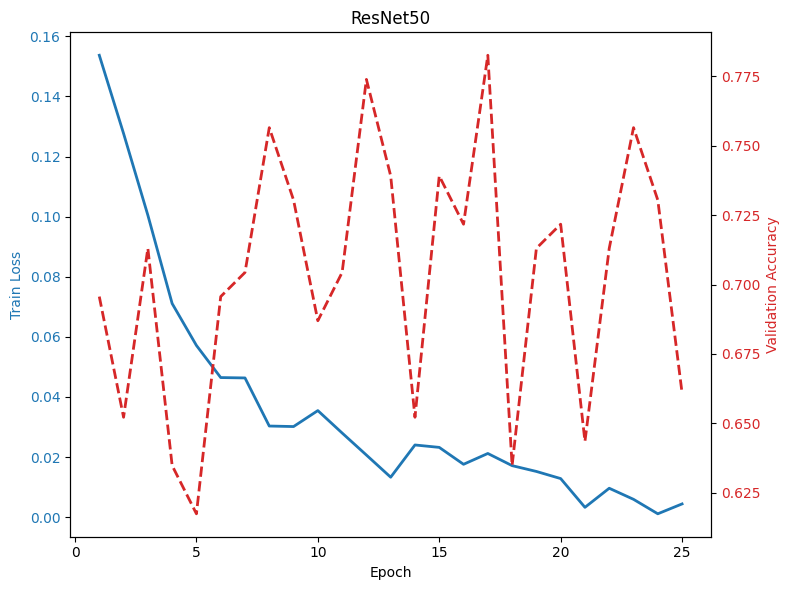

In [83]:
plot_history(pd.read_csv('./ResNet50_Learning_History.csv', index_col=0), model_name='ResNet50')

Всего предсказаний: 230
Количество правильных предсказаний: 164
Относительное количество правильных предсказаний: 0.7130


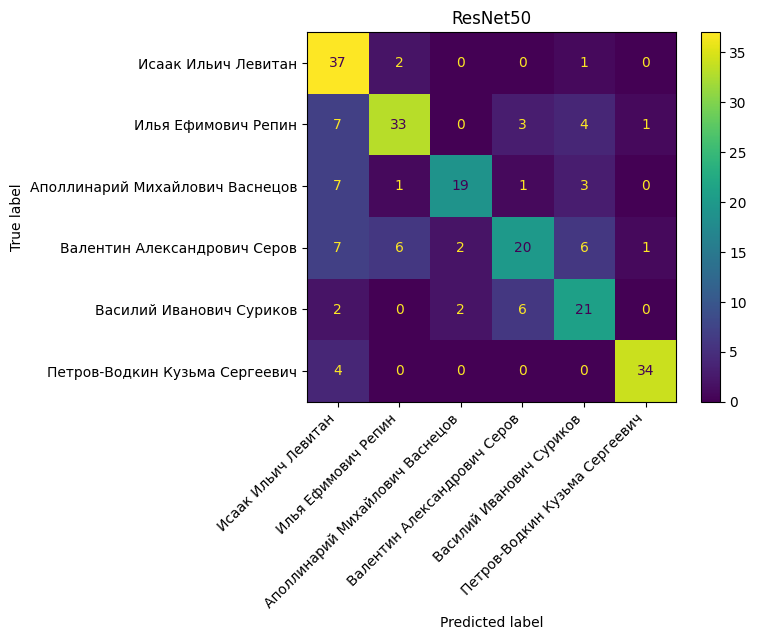

In [132]:
plot_confusion_matrix_with_accuracy(torch.load('./ResNet50.pth'), test_dataset=test_dataset, model_name='ResNet50')
gc.collect()
torch.cuda.empty_cache()

## Модель ResNet101

In [107]:
class ResNet101Classifier(Classifier):
    def __init__(self, num_classes: int, pretrained: bool = True, classifier_dropout: float = 0.25, *args, **kwargs):
        super(ResNet101Classifier, self).__init__(*args, **kwargs)
        self.backbone = models.resnet101(weights=models.ResNet101_Weights.DEFAULT if pretrained else None)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(classifier_dropout),
            nn.Linear(in_features, num_classes)
        )
        self._classifier_pointer = self.backbone.fc
        self._backbone_pointer = nn.Sequential(*list(self.backbone.children())[:-2])
        self.backbone_name = 'ResNet101'
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f'Model would work on {self.device}')
        self.to(self.device)

In [17]:
model = ResNet101Classifier(num_classes, classifier_dropout=0.25)
history = model.train_model(data=train_dataset,
                            validation_data=val_dataset,
                            save_best_model=True,
                            batch_size=8,
                            epochs=25,
                            backbone_learning_rate = 0.0001,
                            classifier_learning_rate = 0.001,
                            mixed_precision=True)
history.to_csv('./ResNet101_Learning_History.csv')

Model would work on cuda
Epoch 1/25, Loss: 0.1534, Validation Accuracy: 0.7217
Best model saved: ./ResNet101.pth
Epoch 2/25, Loss: 0.1363, Validation Accuracy: 0.5304
Epoch 3/25, Loss: 0.1019, Validation Accuracy: 0.5478
Epoch 4/25, Loss: 0.0758, Validation Accuracy: 0.6696
Epoch 5/25, Loss: 0.0505, Validation Accuracy: 0.6174
Epoch 6/25, Loss: 0.0511, Validation Accuracy: 0.6957
Epoch 7/25, Loss: 0.0509, Validation Accuracy: 0.6783
Epoch 8/25, Loss: 0.0346, Validation Accuracy: 0.7043
Epoch 9/25, Loss: 0.0313, Validation Accuracy: 0.7391
Best model saved: ./ResNet101.pth
Epoch 10/25, Loss: 0.0273, Validation Accuracy: 0.7043
Epoch 11/25, Loss: 0.0278, Validation Accuracy: 0.7478
Best model saved: ./ResNet101.pth
Epoch 12/25, Loss: 0.0215, Validation Accuracy: 0.7217
Epoch 13/25, Loss: 0.0196, Validation Accuracy: 0.7304
Epoch 14/25, Loss: 0.0184, Validation Accuracy: 0.6783
Epoch 15/25, Loss: 0.0188, Validation Accuracy: 0.6348
Epoch 16/25, Loss: 0.0133, Validation Accuracy: 0.7130
Ep

GPU - NVIDIA geforce RTX 3060(6gb laptop) (undervolted)<br>
GPU freq ≈ 900MHz<br>
GPU memory freq ≈ 6000MHz<br>
GPU memory usage ≈ 1.4gb<br>
Training time = 10m 22.3s<br>
Best validation accuracy ≈ 0.7478

In [18]:
del model
del history
gc.collect()
torch.cuda.empty_cache()

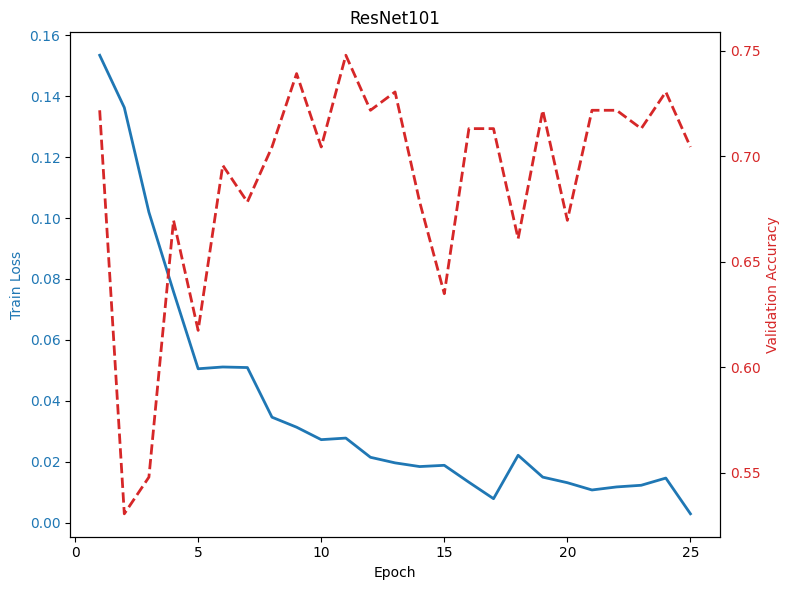

In [84]:
plot_history(pd.read_csv('./ResNet101_Learning_History.csv', index_col=0), model_name='ResNet101')

Всего предсказаний: 230
Количество правильных предсказаний: 169
Относительное количество правильных предсказаний: 0.7348


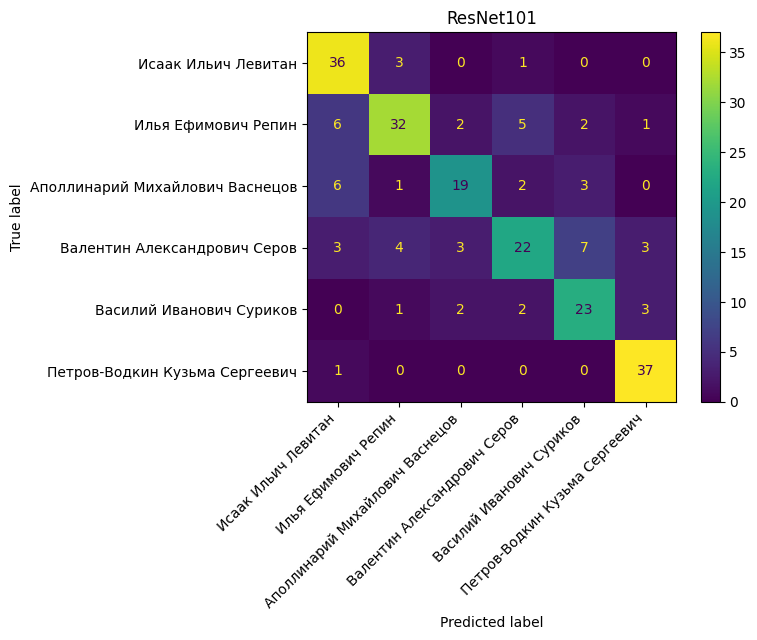

In [133]:
plot_confusion_matrix_with_accuracy(torch.load('./ResNet101.pth'), test_dataset=test_dataset, model_name='ResNet101')
gc.collect()
torch.cuda.empty_cache()

## Модель YOLO11L-cls

In [12]:
data_transforms = transforms.Compose([transforms.Resize((224, 224)),  # YOLO11-cls
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(15),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [13]:
train_dataset = create_dataset(train_indexes, resampled_df, data_transforms)
val_dataset = create_dataset(val_indexes, resampled_df, data_transforms)
test_dataset = create_dataset(test_indexes, resampled_df, data_transforms)
num_classes = len(df['ru_author'].unique())

In [45]:
class YOLO11LClassifier(Classifier):
    def __init__(self, num_classes: int, pretrained: bool = True, classifier_dropout: float = 0.25, *args, **kwargs):
        super(YOLO11LClassifier, self).__init__(*args, **kwargs)
        self.backbone = torch.load('./yolo11l-cls.pt')['model'].model
        in_features = self.backbone[-1].linear.in_features
        self.backbone[-1].drop = nn.Dropout(classifier_dropout)
        self.backbone[-1].linear = nn.Linear(in_features, num_classes)
        self.backbone[-1] = self.backbone[-1].float()
        self._classifier_pointer = self.backbone[-1]
        self._backbone_pointer = self.backbone[:-2]
        self.backbone_name = 'YOLO11L'
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f'Model would work on {self.device}')
        self.to(self.device)
    
    def forward(self, x: torch.Tensor):
        x = self._backbone_pointer.forward(x)
        return self._classifier_pointer.forward(x)
    
    def __call__(self, x: torch.Tensor):
        x = self._backbone_pointer.forward(x)
        return self._classifier_pointer.forward(x)

    def train_model(self,
                    data: ImageDataset,
                    validation_data: Optional[ImageDataset] = None,
                    save_best_model: bool = False,
                    batch_size: int = 32,
                    epochs: int = 10,
                    backbone_learning_rate: float = 0.0001,
                    classifier_learning_rate: float = 0.001,
                    mixed_precision: bool = False) -> pd.DataFrame:
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW([
            {'params': self._backbone_pointer.parameters(), 'lr': backbone_learning_rate},
            {'params': self._classifier_pointer.parameters(), 'lr': classifier_learning_rate}
        ])
        if mixed_precision:
            scaler = torch.amp.grad_scaler.GradScaler(device=self.device)
        val_accuracy = []
        train_loss = []
        self.train()
        for epoch in range(epochs):
            running_loss = 0.0
            for labels, tensors in data.batch_iter_tensors(batch_size, device=self.device):
                tensors = tensors.half()
                optimizer.zero_grad()
                if mixed_precision:
                    with torch.amp.autocast_mode.autocast(self.device.type):
                        output = self(tensors)
                        loss = criterion(output, labels.long())
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    output = self(tensors)
                    loss = criterion(output, labels.long())
                    loss.backward()
                    optimizer.step()
                running_loss += loss.item()
            train_loss.append(running_loss / len(data))
            if validation_data is not None:
                y_pred = self.predict(validation_data, batch_size=batch_size)
                y_true = np.array([i.label for i in val_dataset])
                accuracy = np.sum(y_true == y_pred) / len(y_true)
                print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(data):.4f}, Validation Accuracy: {accuracy:.4f}")
                if save_best_model:
                    if len(val_accuracy) == 0 or (accuracy > max(val_accuracy)):
                        torch.save(self, f=f'./{self.backbone_name}.pth')
                        print(f'Best model saved: ./{self.backbone_name}.pth')
                val_accuracy.append(accuracy)
            else:
                print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(data):.4f}")
        history = pd.DataFrame()
        history['Epoch'] = list(range(1, epochs+1))
        history['Train Loss'] = train_loss
        if validation_data is not None:
            history['Validation Accuracy'] = val_accuracy
        return history
    
    def predict(self, data: ImageDataset, batch_size=32) -> np.ndarray:
        self.eval()
        predictions = []
        with torch.no_grad():
            for _, tensors in data.batch_iter_tensors(batch_size, device=self.device):
                tensors = tensors.half()
                outputs = self._backbone_pointer(tensors)
                outputs = self._classifier_pointer(outputs.float())
                _, predicted = torch.max(outputs, 1)
                predictions.extend(predicted.cpu().numpy())
        return np.array(predictions, dtype=np.uint16)

In [46]:
model = YOLO11LClassifier(num_classes, classifier_dropout=0.25)
history = model.train_model(data=train_dataset,
                            validation_data=val_dataset,
                            save_best_model=True,
                            batch_size=8,
                            epochs=25,
                            backbone_learning_rate = 0.0001,
                            classifier_learning_rate = 0.001,
                            mixed_precision=True)
history.to_csv('./YOLO11L_Learning_History.csv')

Model would work on cuda
Epoch 1/25, Loss: 0.1673, Validation Accuracy: 0.6522
Best model saved: ./YOLO11L.pth
Epoch 2/25, Loss: 0.1812, Validation Accuracy: 0.6522
Epoch 3/25, Loss: 0.1751, Validation Accuracy: 0.6261
Epoch 4/25, Loss: 0.1708, Validation Accuracy: 0.7043
Best model saved: ./YOLO11L.pth
Epoch 5/25, Loss: 0.1680, Validation Accuracy: 0.7217
Best model saved: ./YOLO11L.pth
Epoch 6/25, Loss: 0.1652, Validation Accuracy: 0.7304
Best model saved: ./YOLO11L.pth
Epoch 7/25, Loss: 0.1631, Validation Accuracy: 0.7217
Epoch 8/25, Loss: 0.1616, Validation Accuracy: 0.7304
Epoch 9/25, Loss: 0.1596, Validation Accuracy: 0.7217
Epoch 10/25, Loss: 0.1577, Validation Accuracy: 0.7217
Epoch 11/25, Loss: 0.1555, Validation Accuracy: 0.7652
Best model saved: ./YOLO11L.pth
Epoch 12/25, Loss: 0.1555, Validation Accuracy: 0.7130
Epoch 13/25, Loss: 0.1548, Validation Accuracy: 0.7826
Best model saved: ./YOLO11L.pth
Epoch 14/25, Loss: 0.1528, Validation Accuracy: 0.7130
Epoch 15/25, Loss: 0.1

GPU - NVIDIA geforce RTX 3060(6gb laptop) (undervolted)<br>
GPU freq ≈ 900MHz<br>
GPU memory freq ≈ 6000MHz<br>
GPU memory usage ≈ 0.6gb<br>
Training time = 8m 0.6s<br>
Best validation accuracy ≈ 0.7826

In [85]:
del model
del history
gc.collect()
torch.cuda.empty_cache()

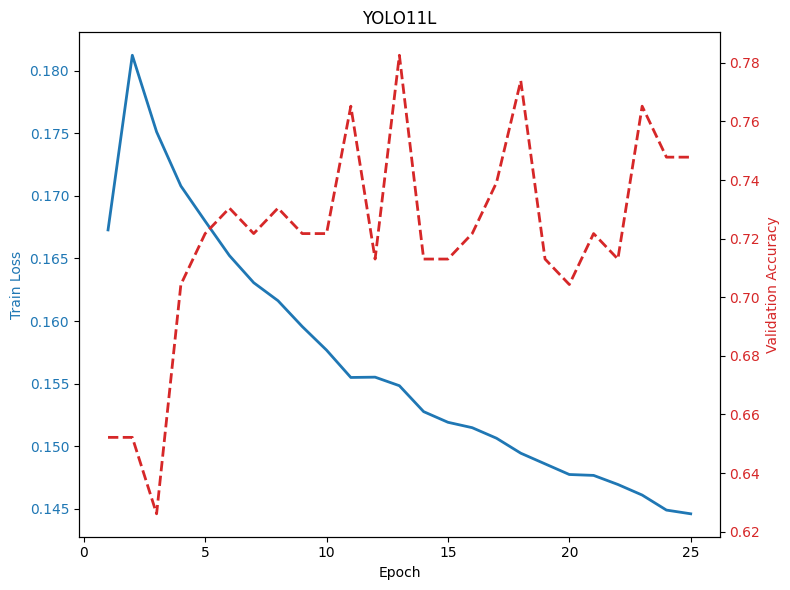

In [86]:
plot_history(pd.read_csv('./YOLO11L_Learning_History.csv', index_col=0), model_name='YOLO11L')

Всего предсказаний: 230
Количество правильных предсказаний: 170
Относительное количество правильных предсказаний: 0.7391


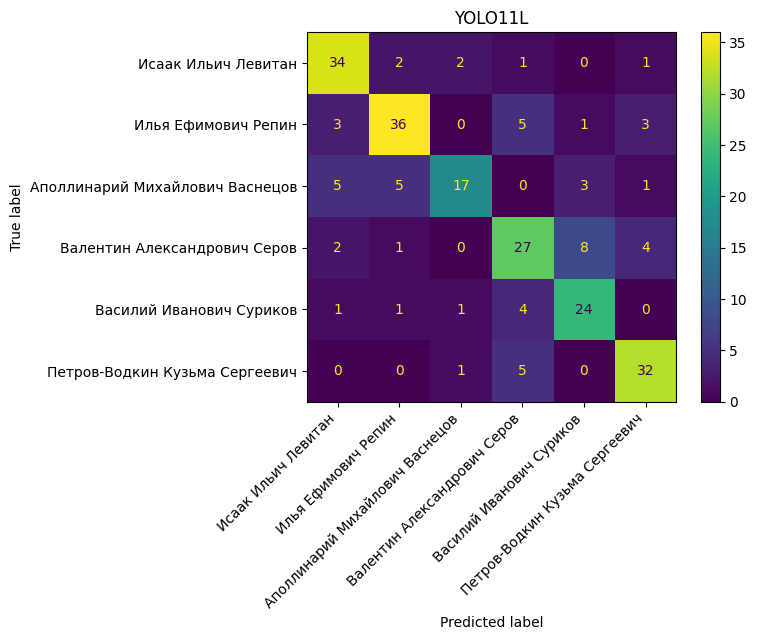

In [134]:
plot_confusion_matrix_with_accuracy(torch.load('./YOLO11L.pth'), test_dataset=test_dataset, model_name='YOLO11L')
gc.collect()
torch.cuda.empty_cache()

## Модель YOLO11X-cls

In [48]:
class YOLO11XClassifier(Classifier):
    def __init__(self, num_classes: int, pretrained: bool = True, classifier_dropout: float = 0.25, *args, **kwargs):
        super(YOLO11XClassifier, self).__init__(*args, **kwargs)
        self.backbone = torch.load('./yolo11x-cls.pt')['model'].model
        in_features = self.backbone[-1].linear.in_features
        self.backbone[-1].drop = nn.Dropout(classifier_dropout)
        self.backbone[-1].linear = nn.Linear(in_features, num_classes)
        self.backbone[-1] = self.backbone[-1].float()
        self._classifier_pointer = self.backbone[-1]
        self._backbone_pointer = self.backbone[:-2]
        self.backbone_name = 'YOLO11X'
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f'Model would work on {self.device}')
        self.to(self.device)
    
    def forward(self, x: torch.Tensor):
        x = self._backbone_pointer.forward(x)
        return self._classifier_pointer.forward(x)
    
    def __call__(self, x: torch.Tensor):
        x = self._backbone_pointer.forward(x)
        return self._classifier_pointer.forward(x)

    def train_model(self,
                    data: ImageDataset,
                    validation_data: Optional[ImageDataset] = None,
                    save_best_model: bool = False,
                    batch_size: int = 32,
                    epochs: int = 10,
                    backbone_learning_rate: float = 0.0001,
                    classifier_learning_rate: float = 0.001,
                    mixed_precision: bool = False) -> pd.DataFrame:
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW([
            {'params': self._backbone_pointer.parameters(), 'lr': backbone_learning_rate},
            {'params': self._classifier_pointer.parameters(), 'lr': classifier_learning_rate}
        ])
        if mixed_precision:
            scaler = torch.amp.grad_scaler.GradScaler(device=self.device)
        val_accuracy = []
        train_loss = []
        self.train()
        for epoch in range(epochs):
            running_loss = 0.0
            for labels, tensors in data.batch_iter_tensors(batch_size, device=self.device):
                tensors = tensors.half()
                optimizer.zero_grad()
                if mixed_precision:
                    with torch.amp.autocast_mode.autocast(self.device.type):
                        output = self(tensors)
                        loss = criterion(output, labels.long())
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    output = self(tensors)
                    loss = criterion(output, labels.long())
                    loss.backward()
                    optimizer.step()
                running_loss += loss.item()
            train_loss.append(running_loss / len(data))
            if validation_data is not None:
                y_pred = self.predict(validation_data, batch_size=batch_size)
                y_true = np.array([i.label for i in val_dataset])
                accuracy = np.sum(y_true == y_pred) / len(y_true)
                print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(data):.4f}, Validation Accuracy: {accuracy:.4f}")
                if save_best_model:
                    if len(val_accuracy) == 0 or (accuracy > max(val_accuracy)):
                        torch.save(self, f=f'./{self.backbone_name}.pth')
                        print(f'Best model saved: ./{self.backbone_name}.pth')
                val_accuracy.append(accuracy)
            else:
                print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(data):.4f}")
        history = pd.DataFrame()
        history['Epoch'] = list(range(1, epochs+1))
        history['Train Loss'] = train_loss
        if validation_data is not None:
            history['Validation Accuracy'] = val_accuracy
        return history
    
    def predict(self, data: ImageDataset, batch_size=32) -> np.ndarray:
        self.eval()
        predictions = []
        with torch.no_grad():
            for _, tensors in data.batch_iter_tensors(batch_size, device=self.device):
                tensors = tensors.half()
                outputs = self._backbone_pointer(tensors)
                outputs = self._classifier_pointer(outputs.float())
                _, predicted = torch.max(outputs, 1)
                predictions.extend(predicted.cpu().numpy())
        return np.array(predictions, dtype=np.uint16)

In [50]:
model = YOLO11XClassifier(num_classes, classifier_dropout=0.25)
history = model.train_model(data=train_dataset,
                            validation_data=val_dataset,
                            save_best_model=True,
                            batch_size=8,
                            epochs=25,
                            backbone_learning_rate = 0.0001,
                            classifier_learning_rate = 0.001,
                            mixed_precision=True)
history.to_csv('./YOLO11X_Learning_History.csv')

Model would work on cuda
Epoch 1/25, Loss: 0.1719, Validation Accuracy: 0.6957
Best model saved: ./YOLO11X.pth
Epoch 2/25, Loss: 0.1814, Validation Accuracy: 0.6957
Epoch 3/25, Loss: 0.1754, Validation Accuracy: 0.7217
Best model saved: ./YOLO11X.pth
Epoch 4/25, Loss: 0.1712, Validation Accuracy: 0.6957
Epoch 5/25, Loss: 0.1675, Validation Accuracy: 0.6870
Epoch 6/25, Loss: 0.1652, Validation Accuracy: 0.7565
Best model saved: ./YOLO11X.pth
Epoch 7/25, Loss: 0.1627, Validation Accuracy: 0.7478
Epoch 8/25, Loss: 0.1611, Validation Accuracy: 0.7739
Best model saved: ./YOLO11X.pth
Epoch 9/25, Loss: 0.1581, Validation Accuracy: 0.7739
Epoch 10/25, Loss: 0.1571, Validation Accuracy: 0.8000
Best model saved: ./YOLO11X.pth
Epoch 11/25, Loss: 0.1551, Validation Accuracy: 0.7826
Epoch 12/25, Loss: 0.1556, Validation Accuracy: 0.7826
Epoch 13/25, Loss: 0.1532, Validation Accuracy: 0.7652
Epoch 14/25, Loss: 0.1526, Validation Accuracy: 0.7913
Epoch 15/25, Loss: 0.1517, Validation Accuracy: 0.8174

GPU - NVIDIA geforce RTX 3060(6gb laptop) (undervolted)<br>
GPU freq ≈ 900MHz<br>
GPU memory freq ≈ 6000MHz<br>
GPU memory usage ≈ 0.4gb<br>
Training time = 7m 45.8s<br>
Best validation accuracy ≈ 0.8522

In [ ]:
del model
del history
gc.collect()
torch.cuda.empty_cache()

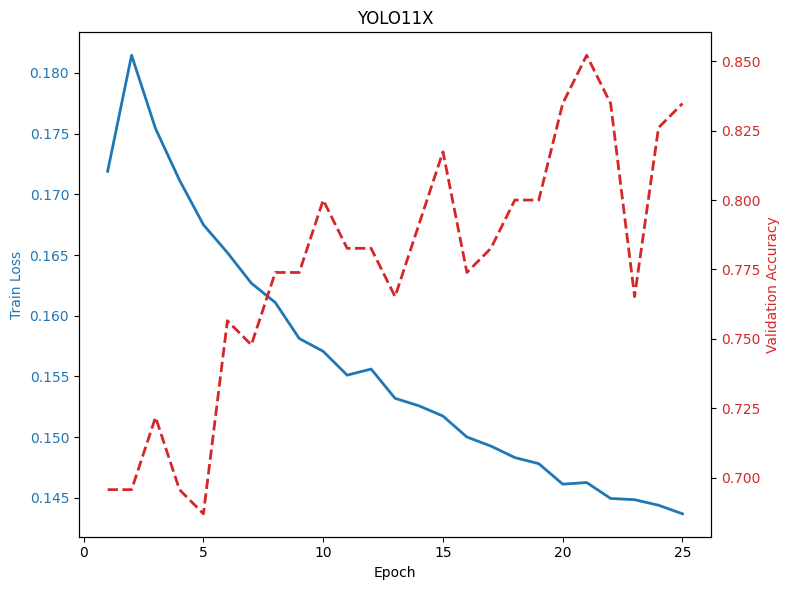

In [99]:
plot_history(pd.read_csv('./YOLO11X_Learning_History.csv', index_col=0), model_name='YOLO11X')

Всего предсказаний: 230
Количество правильных предсказаний: 175
Относительное количество правильных предсказаний: 0.7609


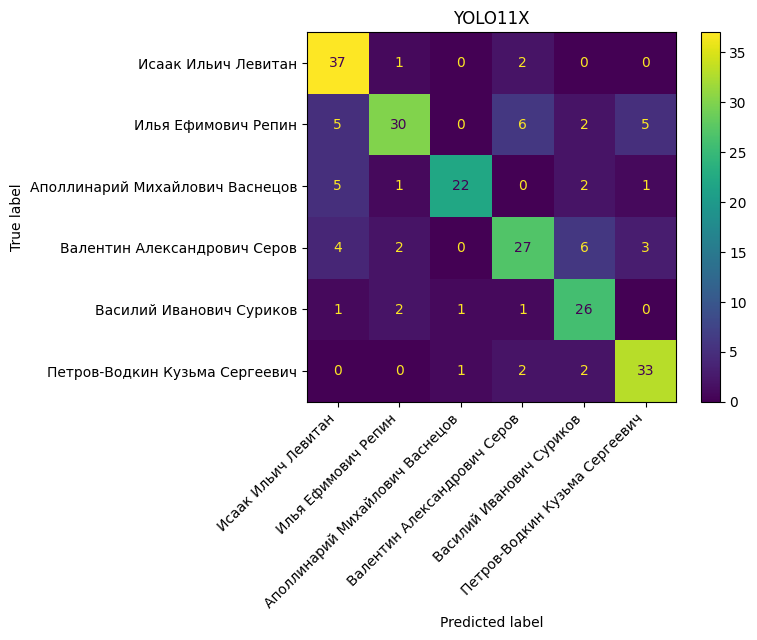

In [135]:
plot_confusion_matrix_with_accuracy(torch.load('./YOLO11X.pth'), test_dataset=test_dataset, model_name='YOLO11X')
gc.collect()
torch.cuda.empty_cache()